# FBGVI Numerical Experiments

## Setup

In [1]:
# math
import numpy as np
from numpy.random import multivariate_normal as mvn
from scipy.stats import ortho_group, uniform, bernoulli
from scipy.linalg import sqrtm
from scipy.optimize import minimize

# plotting/visualization
import matplotlib.pyplot as plt
from cycler import cycler
from jax import hessian

# python utils
from functools import partial

## Utils

### Matrix utils

#### Generate random matrices

In [2]:
def gen_matrix_with_eigs(eigs):
    """
    Generates a symmetric matrix with eigenvalues `eigs`.
    """
    dim = len(eigs)
    x = ortho_group.rvs(dim)
    return x.T @ np.diag(eigs) @ x

def gen_matrix_with_eigbounds(low, high, dim: int):
    """
    Generates a symmetric matrix with eigenvalues within [low, high].
    """
    eigs = low + (high - low) * uniform.rvs(size=dim)
    return gen_matrix_with_eigs(eigs)

#### Clip matrix

In [3]:
def clip_matrix(M: np.array, upper):
    """
    Assuming that M is PSD, return the matrix obtained by clipping the singular values at upper.
    """
    eigs = np.linalg.eig(M)
    return eigs[1] @ np.diag(np.minimum(eigs[0], upper)) @ eigs[1].T

### Distance measures

#### Wasserstein

In [4]:
def wasserstein_dist(mu_0, mu_1, Sigma_0, Sigma_1):
    """
    Return the squared W2 distance between N(mu_0, Sigma_0), N(mu_1, Sigma_1).
    """
    half_0 = sqrtm(Sigma_0)
    half_1 = sqrtm(Sigma_1)
    return np.sum((mu_0 - mu_1) ** 2) + np.sum((half_0 - half_1) ** 2)

#### Entropy, KL between Gaussians

In [5]:
def H(mu, Sigma):
    """
    Return the negentropy of N(mu, Sigma).
    """
    d = len(mu)
    assert d == Sigma.shape[0] and d == Sigma.shape[1]
    return -(
        d/2 * (1 + np.log(2 * np.pi))
        + 1/2 * np.log(np.linalg.det(Sigma))
    )

def kl_divergence(mu_0, mu_1, Sigma_0, Sigma_1):
    """
    Return the KL divergence
    KL( N(mu_0, Sigma_0) || N(mu_1, Sigma_1) ).
    """
    d = mu_0.shape[0]
    
    det_0 = np.linalg.det(Sigma_0)
    det_1 = np.linalg.det(Sigma_1)
    Sigma_1_inv = np.linalg.inv(Sigma_1)
    div = np.log(det_1) - np.log(det_0)
    div -= d
    div += (Sigma_1_inv * Sigma_0).sum()
    div += (mu_1 - mu_0).T @ Sigma_1_inv @ (mu_1 - mu_0)
    div /= 2
    return div

### Misc

In [6]:
def softmax(x):
    """
    Univariate softmax function.
    """
    return np.exp(x) / (1 + np.exp(x))

## Experiments

### Experiment parent class

In [7]:
class Experiment():
    """
    Parent class for experiments.
    Implements BWGD and FBGVI and plots results.
    """
    
    def __init__(
        self,
        log_potential,
        gradient_oracle,
        dist_objective,
        dist_objective_name = r"$\mathcal{F}(p_k)$",
        dim = 5, beta = 1,
        grad_V = None,
        hess_V = None,
    ):
        """
        Initialize parameters of experiment:
        - params: dim, beta
        - log_potential
            * takes in a vector x and produces the unnormalized log potential.
        - dist_objective
            * (mu, Sigma) -> objective function to plot
            * by default, we can make this equal to EE_p V - H(p)
        - gradient_oracle
            * (mu, Sigma) -> estimate for (EE nabla V, EE nabla^2 V)
            * default:
                > draw x ~ N(mu, Sigma)
                > compute v = V(x)
                > v.backward()
                > x.grad
        - initialize Sigma_0 at isotropic Gaussian
        """
        
        self.log_potential = log_potential
        self.gradient_oracle = gradient_oracle
        self.dist_objective = dist_objective
        self.dist_objective_name = dist_objective_name
        self.dim = dim
        self.grad_V = grad_V
        self.hess_V = hess_V

        # initialize mean with all zeros
        self.init_mu = np.zeros(dim)

        # initialize Sigma at identity 
        self.init_Sigma = np.eye(dim) / beta
    
    def laplace_approx(self):
        """
        Compute Laplace approximation to target distribution.
        """
        if self.hess_V is None:
            raise NotImplementedError
            
        x0 = np.zeros(self.dim)
        
        # compute MAP
        result = minimize(
            self.log_potential,
            x0,
            jac = self.grad_V,
            hess = self.hess_V
        )
        mu = result.x
        
        # compute Hessian at map
        H = self.hess_V(mu)
        
        # compute inverse of Hessian to obtain Sigma
        Sigma = np.linalg.inv(H)
        
        return mu, Sigma
    
    def run_iter(self, alg, eta, mu, Sigma):
        """
        Run an iteration of the specified algorithm to update (mu, Sigma).
        Returns new (mu, Sigma).
        """
        hat_nabla1, hat_nabla2 = self.gradient_oracle(mu, Sigma)
        
        # compute gradient in mu
        # (update is the same between BWGD and FBGVI)
        # grad_mu = self.Sigma_true_inv @ (mu - self.mu_true)
        mu = mu - eta * hat_nabla1
        
        if alg == "bwgd":
            # compute gradient in Sigma
            M = np.eye(self.dim) - eta * (hat_nabla2 - np.linalg.inv(Sigma))
            Sigma = M @ Sigma @ M
            
        elif alg == "fbgvi":
            # do forward step for the energy
            M_half = np.eye(self.dim) - eta * hat_nabla2
            Sigma_half = M_half @ Sigma @ M_half

            # do backward step for the entropy
            sqrt_matrix = sqrtm(
                Sigma_half @ (Sigma_half + 4 * eta * np.eye(self.dim))
            )
            sqrt_matrix = np.real(sqrt_matrix)
            Sigma = 0.5 * (Sigma_half + 2 * eta * np.eye(self.dim) + sqrt_matrix)
            
        else:
            raise NotImplementedError
    
        return mu, Sigma
    
    def run_experiment(
        self,
        iters_list = 10000, time = 10000,
        init_mu = None, init_Sigma = None,
        plot_laplace = False
    ):
        """
        Run both BWGD and FBGVI.
        """
        alg_dists = []
        time_axes = []
        if init_mu is None:
            init_mu = self.init_mu
        if init_Sigma is None:
            init_Sigma = self.init_Sigma
        
        for iters in iters_list:
            eta = time / iters
            gd_mu_k, gd_Sigma_k = init_mu, init_Sigma
            prox_mu_k, prox_Sigma_k = init_mu, init_Sigma
            
            gd_dists = [self.dist_objective(gd_mu_k, gd_Sigma_k)]
            prox_dists = [self.dist_objective(prox_mu_k, prox_Sigma_k)]
            
            for k in range(iters):
                try:
                    new_mu, new_Sigma = (
                        self.run_iter("bwgd", eta, gd_mu_k, gd_Sigma_k)
                    )
                    gd_mu_k, gd_Sigma_k = new_mu, new_Sigma
                    gd_dists.append(self.dist_objective(gd_mu_k, gd_Sigma_k))
                except np.linalg.LinAlgError:
                    still_psd = False
                    print("np linalg error from trying to sample from MVN!")
                    gd_dists.append(gd_dists[-1])
            for k in range(iters):
                new_mu, new_Sigma = self.run_iter("fbgvi", eta, prox_mu_k, prox_Sigma_k)
                prox_mu_k, prox_Sigma_k = new_mu, new_Sigma
                prox_dists.append(self.dist_objective(prox_mu_k, prox_Sigma_k))
            
            alg_dists += [
                (fr'BWGD, $\eta = {eta:.3f}$', gd_dists),
                (fr'FBGVI, $\eta = {eta:.3f}$', prox_dists)
            ]
            
            time_axes += [
                np.linspace(0, time, iters+1),
                np.linspace(0, time, iters+1)
            ]
        
        self.plot_results(
            time_axes, alg_dists, plot_laplace = plot_laplace
        )
    
    def plot_results(
        self, time_axes, alg_dists, ax = None, plot_laplace = False
    ):
        """
        Plot distances and label results for all the algorithms of interest.
        """
        
        # configure plot
        
        plt.title(fr"{self.dist_objective_name} over iterations")
        plt.xlabel(r"time elapsed ($\eta \times \# $iters)")
        plt.ylabel(self.dist_objective_name)
            
        fig = plt.gcf()
        fig.set_size_inches(8, 5)
        fig.set_dpi(160)
        
        if ax is None:
            ax = plt.gca()
        ax.set_prop_cycle(
            cycler('color', list(plt.rcParams["axes.prop_cycle"].by_key()["color"])) *
            cycler('linestyle', ['-', '--'])
        )
        
        for time, (alg_name, dists) in zip(time_axes, alg_dists):
            """
            Plot distances and label results for particular algorithm of interest.
            """
            dists = np.array(dists)
            ax.plot(time, dists, label = alg_name, linewidth=0.8)
        if plot_laplace:
            # draw laplace approximation error
            laplace_mu, laplace_Sigma = self.laplace_approx()
            ax.axhline(
                self.dist_objective(laplace_mu, laplace_Sigma),
                label="Laplace approx"
            )
            
        plt.legend()
        plt.show()

### Gaussian experiment

In [8]:
class GaussianExperiment(Experiment):
    """
    Run convergence experiment for different algorithms on randomly generated target.
    """
    
    def __init__(
        self, dim = 5, alpha = 0.01, beta = 1,
        stochastic = False,
        W2 = False
    ):
        """
        Initialize parameters of experiment:
        - dim, alpha
        - true (mu, Sigma) and precomputed Sigma^{-1}
        - nabla V(x)
        - initial Sigma for experiments
        """
        
        """
        define potential
        V = 1/2 (x - mu) Sigma^-1 (x - mu)
        """
        def log_potential(x, mu, Sigma_inv):
            assert x.shape[0] == mu.shape[0]
            first = x.T - mu
            second = np.dot(Sigma_inv, (x.T - mu).T)
            return 1/2 * np.dot(
                first,
                second
            )
        
        # randomly initialize mu, Sigma
        mu_true = uniform.rvs(size = (dim, ))
        Sigma_true = gen_matrix_with_eigs(
            np.geomspace(1/beta, 1/alpha, dim)
        )
        Sigma_true_inv = np.linalg.inv(Sigma_true)
        
        log_potential_pure = partial(
            log_potential, mu = mu_true, Sigma_inv = Sigma_true_inv
        )
        
        if not stochastic:
            def gradient_oracle(mu, Sigma):
                nabla_1 = Sigma_true_inv @ (mu - mu_true)
                nabla_2 = Sigma_true_inv
                return nabla_1, nabla_2
        else:
            def gradient_oracle(mu, Sigma):
                x = mvn(mu, Sigma)
                nabla_1 = Sigma_true_inv @ (x - mu_true)
                nabla_2 = Sigma_true_inv
                return nabla_1, nabla_2
        
        if W2:
            # distance objective is the W2 distance
            def dist_objective(mu, Sigma):
                return np.log(wasserstein_dist(mu, mu_true, Sigma, Sigma_true))
        else:
            # distance objective is the KL divergence to target
            def dist_objective(mu, Sigma):
                return np.log(kl_divergence(mu, mu_true, Sigma, Sigma_true))
        
        super().__init__(
            log_potential_pure,
            gradient_oracle, 
            dist_objective,
            dist_objective_name = (
                r"$\log W_2^2(p_k, \hat{{\pi}})$" if W2 else
                r"$\log \mathsf{KL}(p_k \Vert \hat{\pi})$"
            ),
            dim = dim
        )

#### Gaussian target, FBGVI vs BWGD (deterministic)

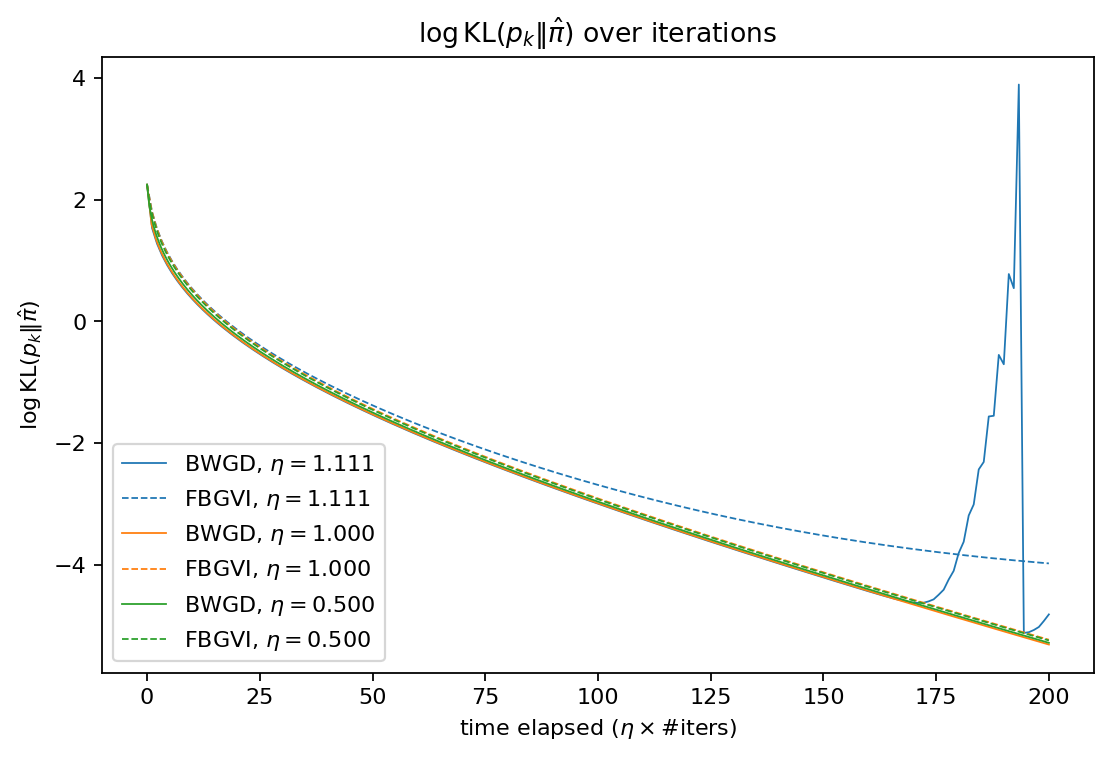

In [9]:
alpha_choice = 5e-3
exp = GaussianExperiment(dim = 10, alpha = alpha_choice, stochastic = False)
exp.run_experiment(iters_list = [180, 200, 400], time = 200)

#### Gaussian target, stochastic FBGVI vs stochastic BWGD

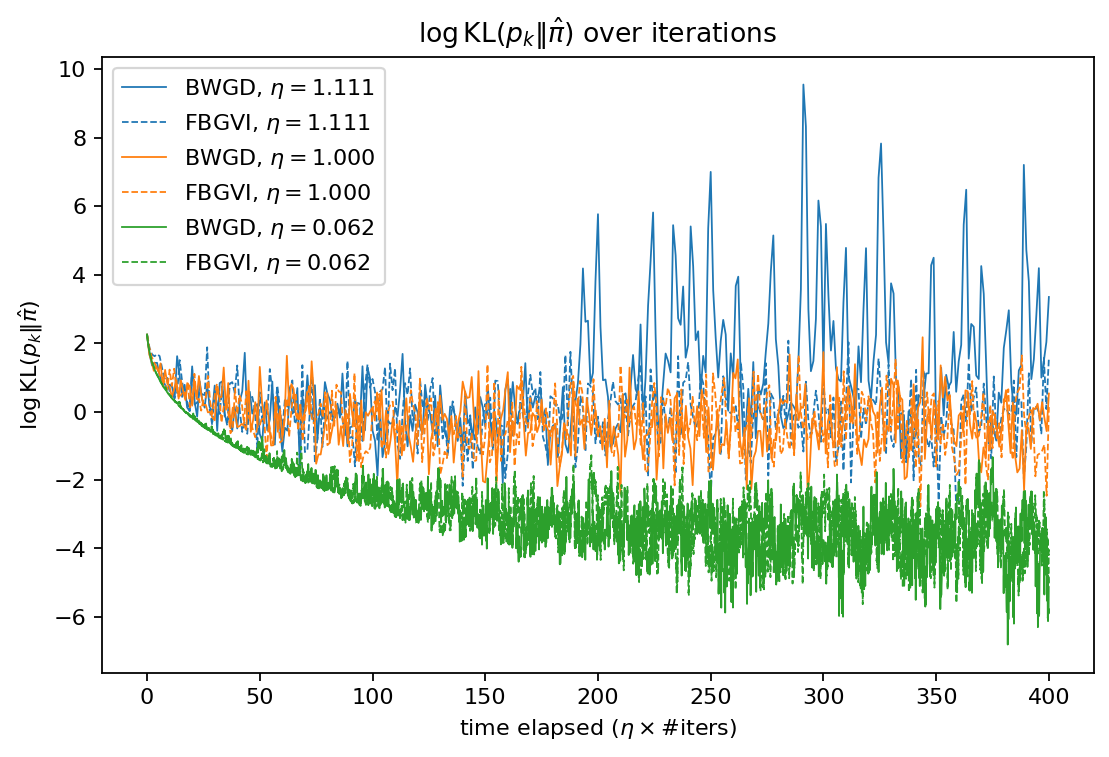

In [10]:
exp = GaussianExperiment(dim = 10, alpha = alpha_choice, stochastic = True)
exp.run_experiment(iters_list = [360, 400, 6400], time = 400)

### Logistic regression experiment

In [11]:
class LogisticRegressionExperiment(Experiment):
    """
    Bayesian logistic regression posterior as target.
    """
    
    def __init__(
        self, dim = 5, n = 20,
        TOTAL_SAMPLES = 1000,
        FI = False
    ):
        """
        Parameters:
        - dim: dimension of theta
        - n: number of samples from generative model
        - TOTAL_SAMPLES:
            total number of samples used to approximate KL divergence
        """
        """
        Define the log potental, gradient, Hessian.
        """
        def log_potential(theta, Y, X):
            """
            Compute log potential.
            V(theta) = sum_{i=1}^n 
                (-Y_i <theta, X_i> + ln(1 + exp <theta, X_i>)).
            """
            first = np.log(1 + np.exp(np.dot(X, theta))).sum(axis=0)
            second = np.dot(Y, np.dot(X, theta))
            return first - second

        def grad_V(theta, Y, X):
            """
            Compute gradient of log potential.
            nabla V(theta) = -sum_{i=1}^n 
                (Y_i - softmax(<theta, X_i>)) X_i.
            """
            first = Y - softmax(np.dot(X, theta)).T
            second = -np.dot(first, X)
            return second.T

        def hess_V(theta, Y, X):
            """
            Compute the Hessian of the log potential.
            nabla^2 V(theta) = sum_{i=1}^n
                (exp <theta, X_i>) / (1 + exp <theta, X_i>)^2 X_i X_i^T
            """
            first = (
                softmax(np.dot(X, theta)) /
                (1 + np.exp(np.dot(X, theta)))
            )
            second = X.T @ np.diag(first) @ X
            return second

        """
        Data generation
        """
        # generate true parameter theta
        true_theta = mvn(np.zeros(dim), np.eye(dim))

        # generate random data matrix X
        X = mvn(
            np.zeros(dim),
            np.eye(dim),
            size=(n)
        )
        
        maxeig = np.linalg.eig(X.T @ X)[0][0]
        X = X / np.sqrt(maxeig)

        # from generative model, draw observations Y
        probs = softmax(X @ true_theta)
        Y = bernoulli.rvs(probs)

        # Define log_potential as a pure function of theta
        log_potential_pure = partial(log_potential, Y = Y, X = X)
        grad_pure = partial(grad_V, Y = Y, X = X)
        hess_pure = partial(hess_V, Y = Y, X = X)

        def gradient_oracle(mu, Sigma):
            theta = mvn(mu, Sigma)
            return grad_pure(theta), hess_pure(theta)
        
        if FI:
            # use empirical BW fisher info as distance objective.
            def dist_objective(mu, Sigma):
                """
                Compute the empirical log Fisher information as a distance objective.
                """
                Sigma_inv = np.linalg.inv(Sigma)
                
                # draw random samples from N(mu, Sigma) to approximate EE||nabla_BW F||^2.
                x = mvn(mu, Sigma, size = TOTAL_SAMPLES).T

                # grad_log = grad_pure(x) - np.dot(Sigma_inv, (x.T - mu).T)
                # assert grad_log.shape
                # return np.log((grad_log ** 2).sum(axis=0).mean())

                grad_stack = grad_pure(x)
                # should be (TOTAL_SAMPLES, dim)
                expected_grad = grad_stack.mean(axis=0)

                # compute expected hessian by integration by parts.
                expected_hess = 1/2 * (np.dot(grad_stack, (x.T - mu))) / TOTAL_SAMPLES
                expected_hess = expected_hess @ Sigma_inv
                # enforce symmetric
                expected_hess = expected_hess + expected_hess.T

                bw_grad = expected_grad + np.dot(x.T - mu, expected_hess).T - np.dot(x.T - mu, Sigma_inv).T
                return np.log((bw_grad ** 2).sum(axis=0).mean())
        else:
            # use empirical KL divergence to unnormalized target.
            def dist_objective(mu, Sigma):
                """
                Compute the empirical KL divergence
                to the unnormalized target as a distance objective.
                """
                # draw random samples from N(mu, Sigma) to approximate F(p_k).
                theta = mvn(mu, Sigma, size = TOTAL_SAMPLES).T

                # compute empirical expectation of V
                log_potentials = log_potential_pure(theta)
                assert log_potentials.shape == (TOTAL_SAMPLES, )
                EE_V = log_potentials.mean()
                return EE_V + H(mu, Sigma)
        
        super().__init__(
            log_potential_pure,
            gradient_oracle,
            dist_objective,
            dist_objective_name = (
                r"$\log \hat\mathbb{E}_{p_k} \Vert \nabla_{BW} \mathcal{F}(p_k) \Vert^2$"
                if FI else
                r"$\mathcal{F}(p_k)$ (empirical)"
            ),
            dim = dim,
            grad_V = grad_pure,
            hess_V = hess_pure
        )

## Stochasic FBGVI vs Stochastic BWGD (plot of log empirical BW gradient norm squared)

/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/_minimize.py:554: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


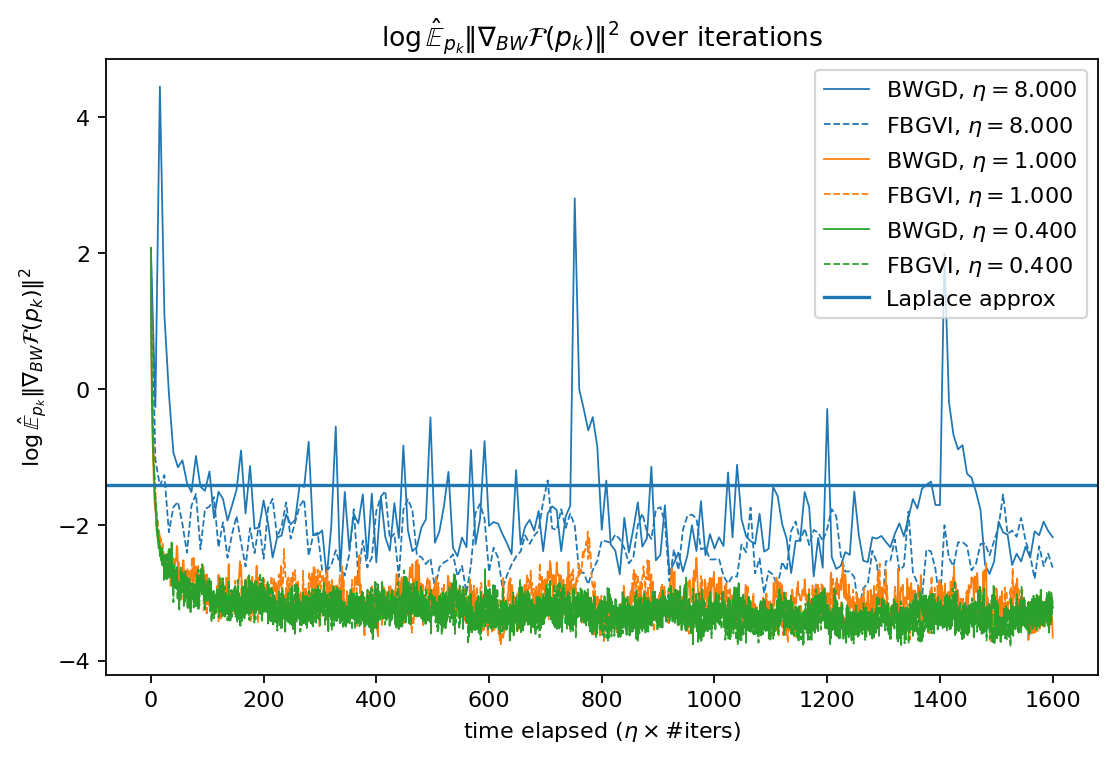

In [12]:
exp = LogisticRegressionExperiment(dim = 10, FI = True)
exp.run_experiment(
    iters_list = [200, 1600, 4000], time = 1600, plot_laplace = True
)

## Stochasic FBGVI vs Stochastic BWGD (plot of objective F(p_k) (approximated using samples))

/var/folders/wr/jllf8ck91qnbzl0lv7xkf2jc0000gn/T/ipykernel_8780/4034293771.py:118: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  theta = mvn(mu, Sigma, size = TOTAL_SAMPLES).T
/var/folders/wr/jllf8ck91qnbzl0lv7xkf2jc0000gn/T/ipykernel_8780/4034293771.py:80: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  theta = mvn(mu, Sigma)


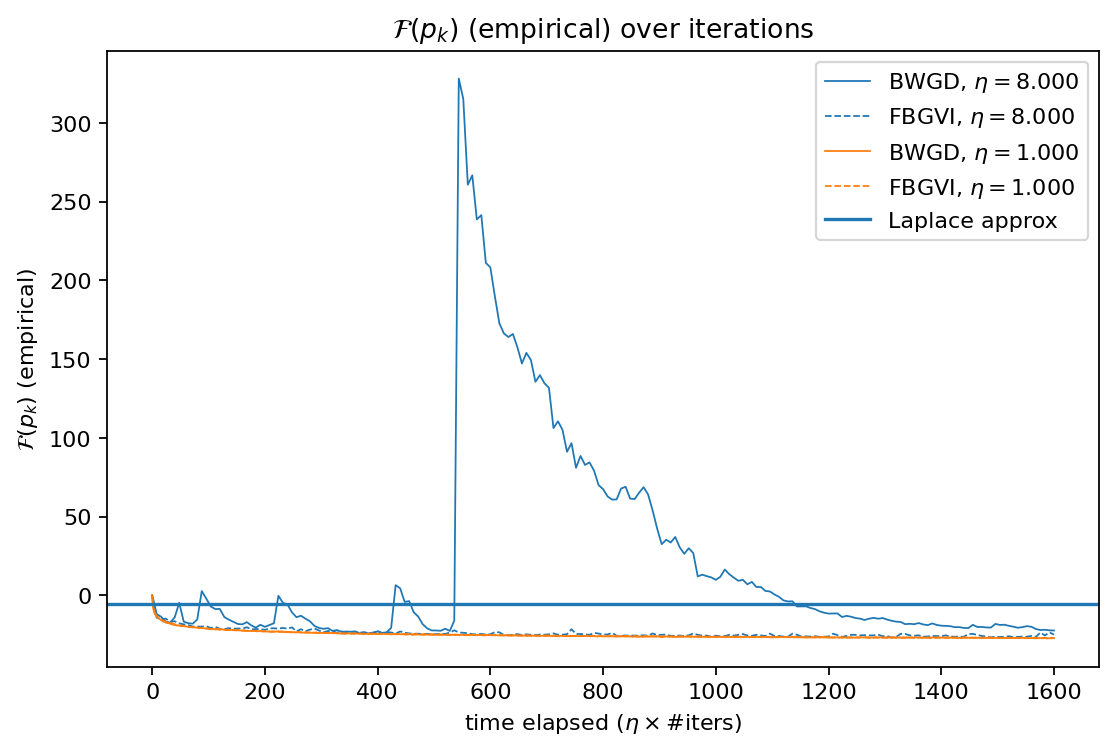

In [13]:
exp = LogisticRegressionExperiment(dim = 10)
exp.run_experiment(
    iters_list = [200, 1600], time = 1600, plot_laplace = True
)